In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import auc, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, make_scorer
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import CondensedNearestNeighbour, NeighbourhoodCleaningRule, RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler 
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, EasyEnsembleClassifier
import warnings
warnings.filterwarnings(action='ignore')
from google.colab import files
%matplotlib inline

rcParams['figure.figsize'] = 12,8

# Loading the Data

In [0]:
RANDOM_STATE = 123

In [0]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data"
columns = ["mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "class"]

In [4]:
df = pd.read_csv(url, header=None, sep=r"\s+", names=columns, usecols=list(range(1,10)))
df.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [0]:
def process_data(df):
  encoder = LabelEncoder()
  y = encoder.fit_transform(df['class'])
  X = df[df.columns[:-1]].values
  return X, y

In [0]:
def process_scaled_data(df):
  l_encoder = LabelEncoder()
  scaler = MinMaxScaler()
  y = l_encoder.fit_transform(df['class'])
  X = df[df.columns[:-1]].values
  X = scaler.fit_transform(X)
  return X, y

In [0]:
X, y = process_data(df)

In [0]:
def make_over_sample(X, y, random_state=0):
  ros = RandomOverSampler(random_state=random_state)
  return ros.fit_resample(X, y)


In [0]:
def make_under_sample(X, y, method=NeighbourhoodCleaningRule, random_state=0):
  clf = method(random_state=random_state)
  return clf.fit_resample(X, y)

X_u, y_u = make_under_sample(X, y, random_state=RANDOM_STATE)
Counter(y_u).most_common()

[(0, 298),
 (7, 208),
 (6, 119),
 (5, 113),
 (3, 35),
 (2, 22),
 (4, 18),
 (8, 9),
 (1, 5)]

## Classifiers 

- Random Forest
- logistic regression
- svc
- AdaBoost

In [0]:
rf_params = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [0]:
ros = RandomOverSampler(random_state=RANDOM_STATE)

In [0]:
rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_bal = BalancedRandomForestClassifier(random_state=RANDOM_STATE)

In [0]:
skf = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE)
clf1_m = {"fpr":[], "tpr":[], "th":[], "mean_fpr":None, "mean_tpr":None}
clf2_m = {"fpr":[], "tpr":[], "th":[], "mean_fpr":None, "mean_tpr":None}

for train_index, test_index in skf.split(X, y):
  X_train = X[train_index]
  y_train = y[train_index]
  X_test = X[test_index]
  y_test = y[test_index]
  clone_clf = clone(rf_clf)
  clone_bal = clone(rf_bal)
  #scorer = make_scorer(loss_func, greater_is_better=True)
  grid_clf = GridSearchCV(estimator=clone_clf, param_grid=rf_params, cv=5, verbose=2, scoring="f1_macro")
  grid_bal = GridSearchCV(estimator=clone_bal, param_grid=rf_params, cv=5, verbose=2, scoring="f1_macro")
  grid_clf.fit(X_train, y_train)
  print("base classifier trained")
  grid_bal.fit(X_train, y_train)
  print(f1_score(y_test, grid_clf.predict(X_test), average="macro"))
  print(f1_score(y_test, grid_bal.predict(X_test), average="macro"))
  break

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 17.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 27.5min finished


0.5472737391411566
0.5523288546320713


## Spliting  dataset

In [0]:
skf = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE)
clf1_m = {"fpr":[], "tpr":[], "th":[], "mean_fpr":None, "mean_tpr":None}
clf2_m = {"fpr":[], "tpr":[], "th":[], "mean_fpr":None, "mean_tpr":None}

for train_index, test_index in skf.split(X, y):
  X_train = X[train_index]
  y_train = y[train_index]
  X_test = X[test_index]
  y_test = y[test_index]
  break

In [0]:
dt_grid = {'max_depth': np.arange(3, 10)}

In [0]:
tree = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), dt_grid, cv=5, verbose=1, scoring="f1_macro")

In [0]:
tree.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=1)

In [0]:
tree.best_params_

{'max_depth': 6}

In [0]:
ada_params = {"n_estimators":[10, 50, 100, 500, 1000, 5000],
         "learning_rate":[0.1, 0.5, 0.75, 1.],
         "algorithm":['SAMME', 'SAMME.R']
         }

In [0]:
ada_clf = GridSearchCV(AdaBoostClassifier(random_state=RANDOM_STATE), param_grid=ada_params, cv=5, scoring="f1_macro")

In [0]:
ada_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=123),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 50, 100, 500, 1000, 5000], 'learning_rate': [0.1, 0.5, 0.75, 1.0], 'algorithm': ['SAMME', 'SAMME.R']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [0]:
ada_clf.best_params_

{'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 100}

In [0]:
ada_clf.best_score_

0.3719922227491274

In [0]:
f1_score(y_test, ada_clf.predict(X_test), average="macro")

0.33503348070454997

In [0]:
easy_params = {"n_estimators":[10, 50, 100, 500, 1000, 5000]
         }

In [0]:
easy_clf = GridSearchCV(EasyEnsembleClassifier(random_state=RANDOM_STATE, n_jobs=-1), param_grid=easy_params, verbose=2, cv=5, scoring="f1_macro")

In [0]:
easy_clf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. n_estimators=10, total=   2.1s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] .................................. n_estimators=10, total=   0.8s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.8s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.8s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.8s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   4.0s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   3.9s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   4.0s
[CV] n_estimators=50 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 65.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=EasyEnsembleClassifier(base_estimator=None, n_estimators=10, n_jobs=-1,
            random_state=123, replacement=False, sampling_strategy='auto',
            verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 50, 100, 500, 1000, 5000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=2)

In [0]:
easy_clf.best_params_

{'n_estimators': 5000}

In [0]:
easy_clf.cv_results_

{'mean_fit_time': array([  0.78354926,   2.58690453,   5.18044262,  25.55043507,
         51.16037607, 257.04909887]),
 'mean_score_time': array([  0.28048644,   1.35322433,   2.71662207,  14.07659836,
         28.73334694, 141.3121295 ]),
 'mean_test_score': array([0.28775767, 0.42832006, 0.43538651, 0.45278233, 0.46070335,
        0.46713447]),
 'mean_train_score': array([0.30370006, 0.44513855, 0.46541431, 0.49993697, 0.50393496,
        0.51032523]),
 'param_n_estimators': masked_array(data=[10, 50, 100, 500, 1000, 5000],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10},
  {'n_estimators': 50},
  {'n_estimators': 100},
  {'n_estimators': 500},
  {'n_estimators': 1000},
  {'n_estimators': 5000}],
 'rank_test_score': array([6, 5, 4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([0.33954712, 0.42738622, 0.40156085, 0.4402553 , 0.44285336,
        0.46342077]),
 'split0_train_score'

In [0]:
f1_score(y_test, easy_clf.predict(X_test), average="macro")

0.5793403885355075

## Experimenting with imbalance ensemble models

In [0]:
def comparison_ensemble(X, y, X_test, y_test, n_estimators, clfs, random_state=0):
  test_metrics = {}
  train_metrics = {}
  for i, clf in enumerate(clfs):
    for n in n_estimators:
      c = clf(n_estimators=n, random_state=random_state)
      c.fit(X, y)
      print(clf, n)
      y_train_pred = c.predict(X)
      y_test_pred = c.predict(X_test)
      if n == n_estimators[0]:
        train_metrics[clfs[i]] = [f1_score(y, y_train_pred, average="macro")]
      else:
        train_metrics[clfs[i]].append(f1_score(y, y_train_pred, average="macro"))
      if n == n_estimators[0]:
        test_metrics[clfs[i]] = [f1_score(y_test, y_test_pred, average="macro")]
      else:
        test_metrics[clfs[i]].append(f1_score(y_test, y_test_pred, average="macro"))
  return test_metrics, train_metrics

In [0]:
tm, trm = comparison_ensemble(X_train, y_train, X_test, y_test, list(range(500, 6000, 500)), [RandomForestClassifier, AdaBoostClassifier, EasyEnsembleClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier], RANDOM_STATE)

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 500
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 1000
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 1500
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 2000
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 2500
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 3000
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 3500
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 4000
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 4500
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 5000
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 5500
<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> 500
<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> 1000
<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> 1500
<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> 2000
<class 'sklearn.ensemble.weight_boosting.AdaBoostCla

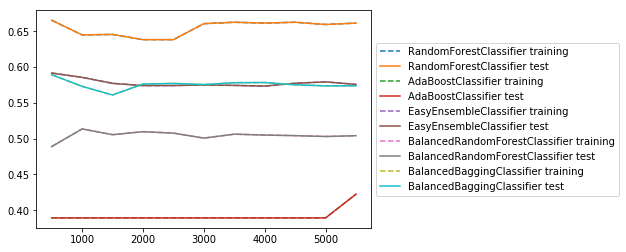

In [0]:
fig = plt.figure()
ax = plt.subplot(111)

for i, j in zip(trm, tm):
  ax.plot(list(range(500, 6000, 500)), tm[i], label="{} training".format(str(i).split(".")[-1][:-2]), linestyle="--")
  ax.plot(list(range(500, 6000, 500)), tm[j], label="{} test".format(str(j).split(".")[-1][:-2]))
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [0]:
newtrm, newtm = comparison_ensemble(X_train, y_train, X_test, y_test, list(range(100, 501, 100)), [RandomForestClassifier, AdaBoostClassifier, EasyEnsembleClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier], RANDOM_STATE)

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 100
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 200
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 300
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 400
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 500
<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> 100
<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> 200
<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> 300
<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> 400
<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> 500
<class 'imblearn.ensemble._easy_ensemble.EasyEnsembleClassifier'> 100
<class 'imblearn.ensemble._easy_ensemble.EasyEnsembleClassifier'> 200
<class 'imblearn.ensemble._easy_ensemble.EasyEnsembleClassifier'> 300
<class 'imblearn.ensemble._easy_ensemble.EasyEnsembleClassifier'> 400
<class 'imblearn.ensemble._easy_ensemble.EasyEnsembleClassifier'> 500
<class 'imblear

In [0]:
newtrm

{imblearn.ensemble._bagging.BalancedBaggingClassifier: [0.5698445128939464,
  0.5757932157742767,
  0.6035227803340123,
  0.5866875739830685,
  0.5893949467293604],
 imblearn.ensemble._easy_ensemble.EasyEnsembleClassifier: [0.5248042491917728,
  0.5678126291436725,
  0.5800186786118099,
  0.5665677717239267,
  0.5917246544878125],
 imblearn.ensemble._forest.BalancedRandomForestClassifier: [0.5066699709643504,
  0.5148366957847326,
  0.4836823233567191,
  0.48461399724257986,
  0.4889413571602478],
 sklearn.ensemble.forest.RandomForestClassifier: [0.5657293364239304,
  0.6585220003792879,
  0.662915704040351,
  0.6686573407628773,
  0.6655184276725177],
 sklearn.ensemble.weight_boosting.AdaBoostClassifier: [0.38921945664416235,
  0.38921945664416235,
  0.38921945664416235,
  0.38921945664416235,
  0.38921945664416235]}

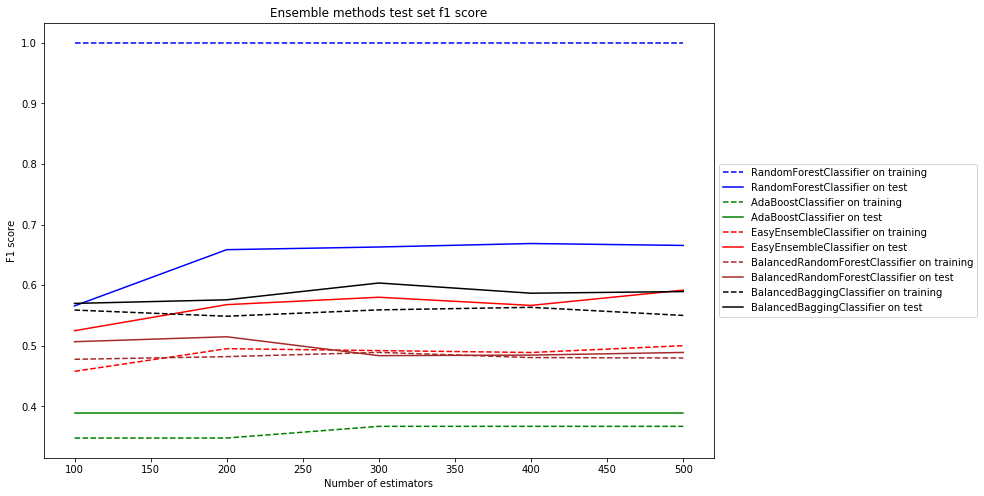

In [0]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
colors = ['blue', 'green', "red", "brown", "black"]

for i, j, c in zip(newtrm, newtm, colors):
  ax.plot(list(range(100, 501, 100)), newtm[j], label="{} on training".format(str(j).split(".")[-1][:-2]), linestyle="--", color=c)
  ax.plot(list(range(100, 501, 100)), newtrm[i], label="{} on test".format(str(i).split(".")[-1][:-2]), color=c)
  
ax.legend()
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("F1 score")
ax.set_xlabel("Number of estimators")
ax.set_title("Ensemble methods test set f1 score")
fig.savefig("ensembletestf1.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
#files.download("ensembletestf1.png")

In [0]:
for i, j in zip(newtm, newtrm):
  print(i, max(newtm[i]), "train")
  print(j, max(newtrm[j]), "test")

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 1.0 train
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.6686573407628773 test
<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> 0.36703737078560134 train
<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> 0.38921945664416235 test
<class 'imblearn.ensemble._easy_ensemble.EasyEnsembleClassifier'> 0.5001188194587796 train
<class 'imblearn.ensemble._easy_ensemble.EasyEnsembleClassifier'> 0.5917246544878125 test
<class 'imblearn.ensemble._forest.BalancedRandomForestClassifier'> 0.48906277127776365 train
<class 'imblearn.ensemble._forest.BalancedRandomForestClassifier'> 0.5148366957847326 test
<class 'imblearn.ensemble._bagging.BalancedBaggingClassifier'> 0.5633909272443094 train
<class 'imblearn.ensemble._bagging.BalancedBaggingClassifier'> 0.6035227803340123 test


In [0]:
rclf = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE)

In [0]:
rclf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

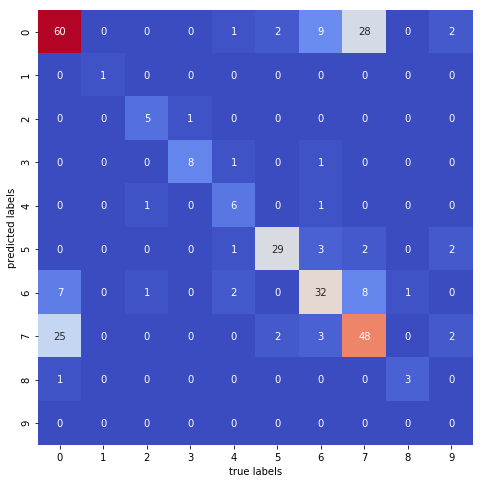

In [0]:
cm = confusion_matrix(y_test, rclf.predict(X_test))
hm = sns.heatmap(cm.T, square=True, annot=True, fmt="d", cbar=False, cmap='coolwarm')
plt.xlabel("true labels")
plt.ylabel("predicted labels")
hm.get_figure().savefig("rfheatmap.png")
files.download("rfheatmap.png")

## Over-samppling

In [0]:
def comparison_oversample(X, y, X_test, y_test, n_estimators, clfs, random_state=0):
  test_metrics = {}
  train_metrics = {}
  X_o, y_o = make_over_sample(X, y, random_state=RANDOM_STATE)
  for i, clf in enumerate(clfs):
    for n in n_estimators:
      c = clf(n_estimators=n, random_state=random_state)
      c.fit(X, y)
      print(str(clf).split(".")[-1][:-2], n)
      y_train_pred = c.predict(X)
      y_test_pred = c.predict(X_test)
      c_o = clf(n_estimators=n, random_state=random_state)
      c_o.fit(X_o, y_o)
      y_train_pred_o = c_o.predict(X)
      y_test_pred_o = c_o.predict(X_test)
      c_name = str(clf).split(".")[-1][:-2]
      
      if n == n_estimators[0]:
        train_metrics[c_name] = [f1_score(y, y_train_pred, average="macro")]
      else:
        train_metrics[c_name].append(f1_score(y, y_train_pred, average="macro"))
      if n == n_estimators[0]:
        test_metrics[c_name] = [f1_score(y_test, y_test_pred, average="macro")]
      else:
        test_metrics[c_name].append(f1_score(y_test, y_test_pred, average="macro"))
        
      if n == n_estimators[0]:
        train_metrics[c_name + "_o"] = [f1_score(y, y_train_pred_o, average="macro")]
      else:
        train_metrics[c_name + "_o"].append(f1_score(y, y_train_pred_o, average="macro"))
      if n == n_estimators[0]:
        test_metrics[c_name + "_o"] = [f1_score(y_test, y_test_pred_o, average="macro")]
      else:
        test_metrics[c_name + "_o"].append(f1_score(y_test, y_test_pred_o, average="macro"))
        
  return test_metrics, train_metrics

In [0]:
ctm, ctrm = comparison_oversample(X_train, y_train, X_test, y_test,
                                  list(range(100, 1001, 100)), 
                                  [RandomForestClassifier, AdaBoostClassifier], RANDOM_STATE)

RandomForestClassifier 100
RandomForestClassifier 200
RandomForestClassifier 300
RandomForestClassifier 400
RandomForestClassifier 500
RandomForestClassifier 600
RandomForestClassifier 700
RandomForestClassifier 800
RandomForestClassifier 900
RandomForestClassifier 1000
AdaBoostClassifier 100
AdaBoostClassifier 200
AdaBoostClassifier 300
AdaBoostClassifier 400
AdaBoostClassifier 500
AdaBoostClassifier 600
AdaBoostClassifier 700
AdaBoostClassifier 800
AdaBoostClassifier 900
AdaBoostClassifier 1000


In [0]:
for i in ctm:
  print(i, max(ctm[i]))

RandomForestClassifier 0.668686945666483
RandomForestClassifier_o 0.6436314265216614
AdaBoostClassifier 0.38921945664416235
AdaBoostClassifier_o 0.3305129431384812


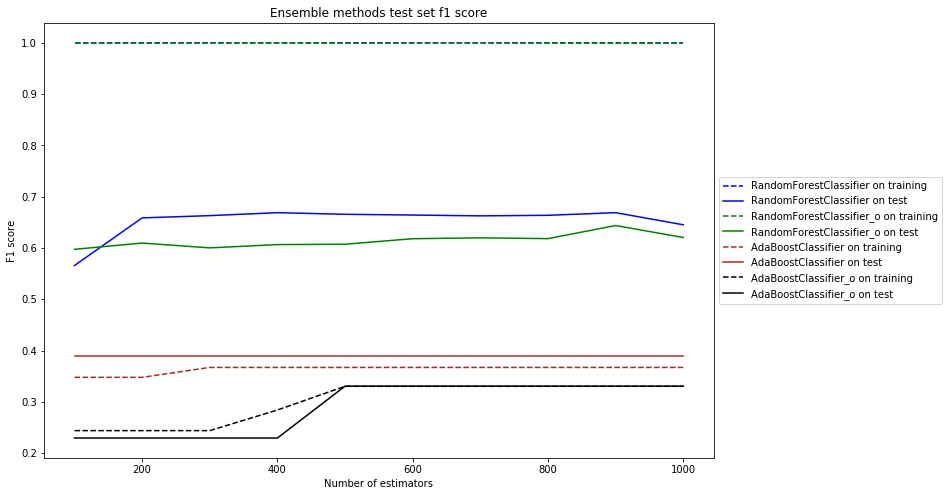

In [0]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
colors = ['blue', 'green', "brown", "black"]

for i, j, c in zip(ctrm, ctm, colors):
  ax.plot(list(range(100, 1001, 100)), ctrm[i], label="{} on training".format(str(j)), linestyle="--", color=c)
  ax.plot(list(range(100, 1001, 100)), ctm[j], label="{} on test".format(str(i)), color=c)
  
ax.legend()
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("F1 score")
ax.set_xlabel("Number of estimators")
ax.set_title("Ensemble methods test set f1 score")
fig.savefig("ensembleoversample.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
#files.download("ensembleoversample.png")

In [0]:
def compare_oversample(X, y, X_test, y_test, n_estimators, clfs, random_state=0):
  test_metrics = {}
  train_metrics = {}
  X_o, y_o = make_over_sample(X, y, random_state=RANDOM_STATE)
  for clf in clfs:
    for n in n_estimators:
      c = clf(n_estimators=n, random_state=random_state)
      c.fit(X, y)
      print(str(clf).split(".")[-1][:-2], n)
      y_train_pred = c.predict(X)
      y_test_pred = c.predict(X_test)
      c_o = clf(n_estimators=n, random_state=random_state)
      c_o.fit(X_o, y_o)
      y_train_pred_o = c_o.predict(X)
      y_test_pred_o = c_o.predict(X_test)
      c_name = str(clf).split(".")[-1][:-2]
      
      if n == n_estimators[0]:
        train_metrics[c_name] = [f1_score(y, y_train_pred, average="macro")]
      else:
        train_metrics[c_name].append(f1_score(y, y_train_pred, average="macro"))
      if n == n_estimators[0]:
        test_metrics[c_name] = [f1_score(y_test, y_test_pred, average="macro")]
      else:
        test_metrics[c_name].append(f1_score(y_test, y_test_pred, average="macro"))
        
      if n == n_estimators[0]:
        train_metrics[c_name + "_o"] = [f1_score(y, y_train_pred_o, average="macro")]
      else:
        train_metrics[c_name + "_o"].append(f1_score(y, y_train_pred_o, average="macro"))
      if n == n_estimators[0]:
        test_metrics[c_name + "_o"] = [f1_score(y_test, y_test_pred_o, average="macro")]
      else:
        test_metrics[c_name + "_o"].append(f1_score(y_test, y_test_pred_o, average="macro"))
        
  return test_metrics, train_metrics

In [0]:
lgr = LogisticRegression(multi_class="multinomial", solver='newton-cg', random_state=RANDOM_STATE)

lgr_param = {"penalty":["l2"],
            "C":[0.001, 0.01, 0.1, 1, 10, 100]}

In [0]:
lgr_grd = GridSearchCV(lgr, param_grid=lgr_param, cv=5, verbose=3, scoring="f1_macro")

In [0]:
lgr_grd.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.001, penalty=l2 .............................................
[CV] ... C=0.001, penalty=l2, score=0.04728434504792332, total=   0.1s
[CV] C=0.001, penalty=l2 .............................................
[CV] .. C=0.001, penalty=l2, score=0.047435897435897434, total=   0.1s
[CV] C=0.001, penalty=l2 .............................................
[CV] .. C=0.001, penalty=l2, score=0.047435897435897434, total=   0.1s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ... C=0.001, penalty=l2, score=0.04774193548387097, total=   0.1s
[CV] C=0.001, penalty=l2 .............................................
[CV] ... C=0.001, penalty=l2, score=0.05339105339105339, total=   0.1s
[CV] C=0.01, penalty=l2 ..............................................
[CV] .... C=0.01, penalty=l2, score=0.05322222725420045, total=   0.1s
[CV] C=0.01, penalty=l2 ..............................................
[CV] .... C=0.01, penalty=l2, score=0.05337573830077238, total=   0.1s
[CV] C=0.01, penalty=l2 ..............................................
[CV] .... C=0.01, penalty=l2, score=0.05622977346278317, total=   0.1s
[CV] C=0.01, penalty=l2 ..............................................
[CV] .... C=0.01, penalty=l2, score=0.06447986577181208, total=   0.1s
[CV] C=0.01, penalty=l2 ..............................................
[CV] .... C=0.01, penalty=l2, score=0.07087719298245614, total=   0.1s
[CV] C=0.1, penalty=l2 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=123, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=3)

In [0]:
print(f1_score(y_train, lgr_grd.predict(X_train), average="macro"), f1_score(y_test, lgr_grd.predict(X_test), average="macro"))

0.5847326839851438 0.5542699498541502


In [0]:
X_o, y_o = make_over_sample(X, y, random_state=RANDOM_STATE)

In [0]:
lgr_grd_o = GridSearchCV(lgr, param_grid=lgr_param, cv=5, verbose=3, scoring="f1_macro")

In [0]:
lgr_grd_o.fit(X_o, y_o)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.001, penalty=l2 .............................................
[CV] ... C=0.001, penalty=l2, score=0.44075861212795947, total=   0.1s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ... C=0.001, penalty=l2, score=0.42943579116559405, total=   0.1s
[CV] C=0.001, penalty=l2 .............................................
[CV] .... C=0.001, penalty=l2, score=0.4364680632908982, total=   0.1s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] .... C=0.001, penalty=l2, score=0.4473522176795964, total=   0.1s
[CV] C=0.001, penalty=l2 .............................................
[CV] ... C=0.001, penalty=l2, score=0.46336955490143855, total=   0.1s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ..... C=0.01, penalty=l2, score=0.4717445509931027, total=   0.2s
[CV] C=0.01, penalty=l2 ..............................................
[CV] .... C=0.01, penalty=l2, score=0.45510090815372184, total=   0.1s
[CV] C=0.01, penalty=l2 ..............................................
[CV] .... C=0.01, penalty=l2, score=0.48072087133402713, total=   0.1s
[CV] C=0.01, penalty=l2 ..............................................
[CV] .... C=0.01, penalty=l2, score=0.48048746509123125, total=   0.1s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ..... C=0.01, penalty=l2, score=0.5108334241633528, total=   0.1s
[CV] C=0.1, penalty=l2 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   10.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=123, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=3)

In [0]:
print(f1_score(y_train, lgr_grd_o.predict(X_train), average="macro"), f1_score(y_test, lgr_grd_o.predict(X_test), average="macro"))

0.5105092120711345 0.5568738109066148


In [0]:
svc_param = {"C":[0.001, 0.01, 0.1, 1, 10, 100],
            "degree":[1, 2, 3, 5, 6],
            "gamma":[0.0001, 0.001, 0.01, 0.1],
            "kernel":["linear", "poly", "rbf", "sigmoid"]}

In [0]:
svc_clf = SVC(random_state=RANDOM_STATE)
svc_grid = GridSearchCV(svc_clf, param_grid=svc_param, cv=5, verbose=3, scoring="f1_macro")

In [0]:
svc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.04728434504792332, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.047435897435897434, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.047435897435897434, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.04774193548387097, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.05339105339105339, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=poly, score=0.04728434504792332, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=poly, score=0.047435897435897434, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=poly, score=0.047435897435897434, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=poly, score=0.04774193548387097, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:  3.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=123,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'degree': [1, 2, 3, 5, 6], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=3)

In [0]:
svc_grid.best_params_

{'C': 100, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [0]:
print(f1_score(y_train, svc_grid.predict(X_train), average="macro"), f1_score(y_test, svc_grid.predict(X_test), average="macro"))

0.5923906174514318 0.5981451260681439


In [0]:
svc_grid.fit(X_o, y_o)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.45614088507193395, total=   0.5s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.42385565282908466, total=   0.5s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.5056117389708097, total=   0.5s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.44719541985101746, total=   0.5s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.4988014634887408, total=   0.5s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=poly, score=0.45614088507193395, total=   0.6s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=poly, score=0.42385565282908466, total=   0.6s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=poly, score=0.5056117389708097, total=   0.6s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.001

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed: 47.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=123,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'degree': [1, 2, 3, 5, 6], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=3)

In [0]:
svc_grid.best_params_

{'C': 100, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [0]:
print(f1_score(y_train, svc_grid.predict(X_train), average="macro"), f1_score(y_test, svc_grid.predict(X_test), average="macro"))

0.5980567136537794 0.6069605281263679


## Under-sampling

In [0]:
#CondensedNearestNeighbour, NeighbourhoodCleaningRule, RandomUnderSampler
def comparison_undersample(X, y, X_test, y_test, n_estimators, method, clfs, random_state=0):
  test_metrics = {}
  train_metrics = {}
  X_u, y_u = make_under_sample(X, y, method=method, random_state=RANDOM_STATE)
  for i, clf in enumerate(clfs):
    for n in n_estimators:
      c = clf(n_estimators=n, random_state=random_state)
      c.fit(X, y)
      print(str(clf).split(".")[-1][:-2], n)
      y_train_pred = c.predict(X)
      y_test_pred = c.predict(X_test)
      c_u = clf(n_estimators=n, random_state=random_state)
      c_u.fit(X_u, y_u)
      y_train_pred_u = c_u.predict(X)
      y_test_pred_u = c_u.predict(X_test)
      c_name = str(clf).split(".")[-1][:-2]
      
      if n == n_estimators[0]:
        train_metrics[c_name] = [f1_score(y, y_train_pred, average="macro")]
      else:
        train_metrics[c_name].append(f1_score(y, y_train_pred, average="macro"))
      if n == n_estimators[0]:
        test_metrics[c_name] = [f1_score(y_test, y_test_pred, average="macro")]
      else:
        test_metrics[c_name].append(f1_score(y_test, y_test_pred, average="macro"))
        
      if n == n_estimators[0]:
        train_metrics[c_name + "_u"] = [f1_score(y, y_train_pred_u, average="macro")]
      else:
        train_metrics[c_name + "_u"].append(f1_score(y, y_train_pred_u, average="macro"))
      if n == n_estimators[0]:
        test_metrics[c_name + "_u"] = [f1_score(y_test, y_test_pred_u, average="macro")]
      else:
        test_metrics[c_name + "_u"].append(f1_score(y_test, y_test_pred_u, average="macro"))
        
  return test_metrics, train_metrics

In [0]:
runtm, runtrm = comparison_undersample(X_train, y_train, X_test, y_test,
                                       list(range(100, 1001, 100)), 
                                       RandomUnderSampler,
                                       [RandomForestClassifier, AdaBoostClassifier], RANDOM_STATE)

RandomForestClassifier 100
RandomForestClassifier 200
RandomForestClassifier 300
RandomForestClassifier 400
RandomForestClassifier 500
RandomForestClassifier 600
RandomForestClassifier 700
RandomForestClassifier 800
RandomForestClassifier 900
RandomForestClassifier 1000
AdaBoostClassifier 100
AdaBoostClassifier 200
AdaBoostClassifier 300
AdaBoostClassifier 400
AdaBoostClassifier 500
AdaBoostClassifier 600
AdaBoostClassifier 700
AdaBoostClassifier 800
AdaBoostClassifier 900
AdaBoostClassifier 1000


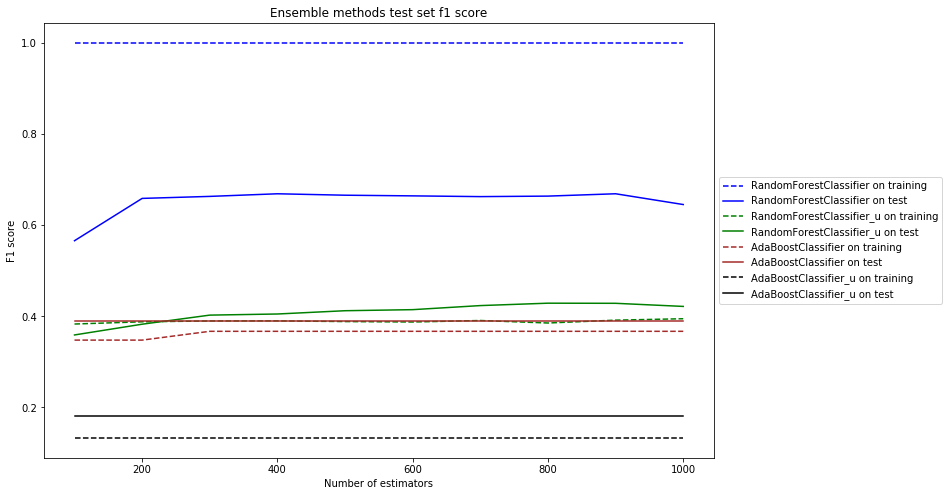

In [0]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
colors = ['blue', 'green', "brown", "black"]

for i, j, c in zip(runtrm, runtm, colors):
  ax.plot(list(range(100, 1001, 100)), runtrm[i], label="{} on training".format(str(j)), linestyle="--", color=c)
  ax.plot(list(range(100, 1001, 100)), runtm[j], label="{} on test".format(str(i)), color=c)
  
ax.legend()
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("F1 score")
ax.set_xlabel("Number of estimators")
ax.set_title("Ensemble methods test set f1 score")
fig.savefig("ensembleundersample.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
#files.download("ensembleundersample.png")

In [0]:
X_u, y_u = make_under_sample(X_train, y_train, method=NeighbourhoodCleaningRule, random_state=RANDOM_STATE)
print(len(Counter(y_u)))
Counter(y_u)

9


Counter({0: 243, 1: 4, 2: 17, 3: 25, 4: 10, 5: 86, 6: 95, 7: 162, 8: 7})

In [0]:
cnntm, cnntrm = comparison_undersample(X_train, y_train, X_test, y_test,
                                       list(range(100, 1001, 100)), 
                                       CondensedNearestNeighbour,
                                       [RandomForestClassifier, AdaBoostClassifier], RANDOM_STATE)

RandomForestClassifier 100
RandomForestClassifier 200
RandomForestClassifier 300
RandomForestClassifier 400
RandomForestClassifier 500
RandomForestClassifier 600
RandomForestClassifier 700
RandomForestClassifier 800
RandomForestClassifier 900
RandomForestClassifier 1000
AdaBoostClassifier 100
AdaBoostClassifier 200
AdaBoostClassifier 300
AdaBoostClassifier 400
AdaBoostClassifier 500
AdaBoostClassifier 600
AdaBoostClassifier 700
AdaBoostClassifier 800
AdaBoostClassifier 900
AdaBoostClassifier 1000


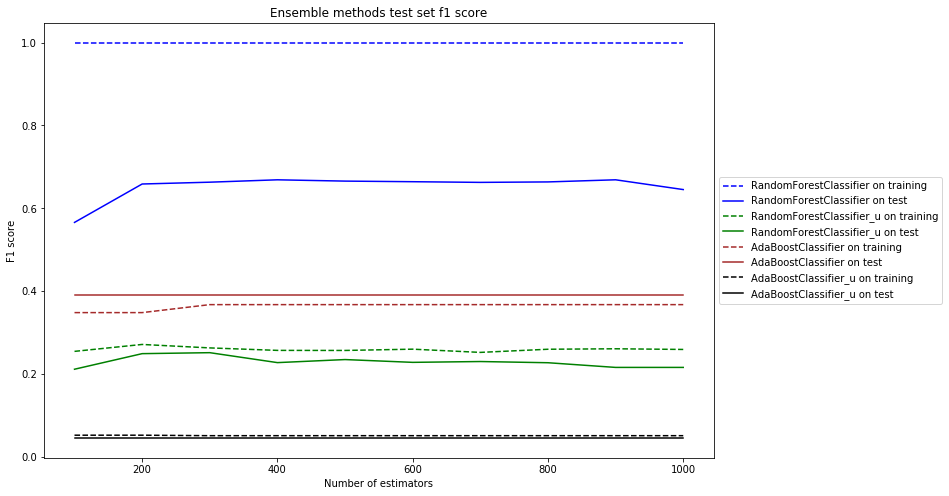

In [0]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
colors = ['blue', 'green', "brown", "black"]

for i, j, c in zip(cnntrm, cnntm, colors):
  ax.plot(list(range(100, 1001, 100)), cnntrm[i], label="{} on training".format(str(j)), linestyle="--", color=c)
  ax.plot(list(range(100, 1001, 100)), cnntm[j], label="{} on test".format(str(i)), color=c)
  
ax.legend()
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("F1 score")
ax.set_xlabel("Number of estimators")
ax.set_title("Ensemble methods test set f1 score")
fig.savefig("ensembleundersample.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
#files.download("ensembleundersample.png")

In [0]:
ncltm, ncltrm = comparison_undersample(X_train, y_train, X_test, y_test,
                                       list(range(100, 1001, 100)), 
                                       NeighbourhoodCleaningRule,
                                       [RandomForestClassifier, AdaBoostClassifier], RANDOM_STATE)

RandomForestClassifier 100
RandomForestClassifier 200
RandomForestClassifier 300
RandomForestClassifier 400
RandomForestClassifier 500
RandomForestClassifier 600
RandomForestClassifier 700
RandomForestClassifier 800
RandomForestClassifier 900
RandomForestClassifier 1000
AdaBoostClassifier 100
AdaBoostClassifier 200
AdaBoostClassifier 300
AdaBoostClassifier 400
AdaBoostClassifier 500
AdaBoostClassifier 600
AdaBoostClassifier 700
AdaBoostClassifier 800
AdaBoostClassifier 900
AdaBoostClassifier 1000


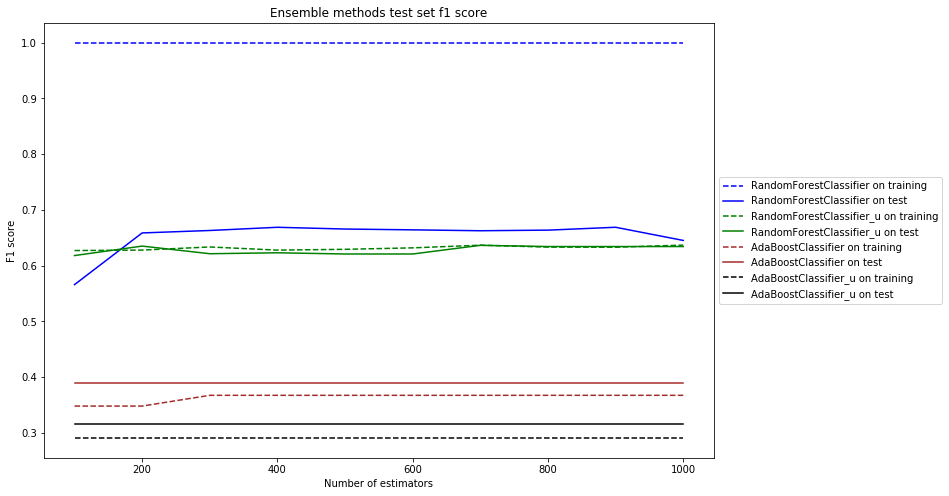

In [0]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
colors = ['blue', 'green', "brown", "black"]

for i, j, c in zip(ncltrm, ncltm, colors):
  ax.plot(list(range(100, 1001, 100)), ncltrm[i], label="{} on training".format(str(j)), linestyle="--", color=c)
  ax.plot(list(range(100, 1001, 100)), ncltm[j], label="{} on test".format(str(i)), color=c)
  
ax.legend()
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("F1 score")
ax.set_xlabel("Number of estimators")
ax.set_title("Ensemble methods test set f1 score")
fig.savefig("ensembleundersample.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
#files.download("ensembleundersample.png")

In [0]:
svc_param = {"C":[0.001, 0.01, 0.1, 1, 10, 100],
            "degree":[1, 2, 3, 5, 6],
            "gamma":[0.0001, 0.001, 0.01, 0.1],
            "kernel":["linear", "poly", "rbf", "sigmoid"]}

In [0]:
svc_grid_base = GridSearchCV(svc_clf, param_grid=svc_param, cv=5, verbose=3, scoring="f1_macro")

In [0]:
svc_grid_base.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.04728434504792332, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.047435897435897434, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.047435897435897434, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.04774193548387097, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.05339105339105339, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=poly, score=0.04728434504792332, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=poly, score=0.047435897435897434, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=poly, score=0.047435897435897434, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=poly, score=0.04774193548387097, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:  3.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=123,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'degree': [1, 2, 3, 5, 6], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=3)

In [0]:
print(f1_score(y_train, svc_grid_base.predict(X_train), average="macro"), f1_score(y_test, svc_grid_base.predict(X_test), average="macro"))

0.5923906174514318 0.5981451260681439


In [0]:
svc_grid_rus = GridSearchCV(svc_clf, param_grid=svc_param, cv=3, verbose=3, scoring="f1_macro")

In [0]:
X_u, y_u = make_under_sample(X_train, y_train, method=RandomUnderSampler, random_state=RANDOM_STATE)

In [0]:
svc_grid_rus.fit(X_u, y_u)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.24166666666666664, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.16666666666666666, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=linear ..................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=linear, score=0.2, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=poly, score=0.24166666666666664, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=poly, score=0.16666666666666666, total=   0.0s
[CV] C=0.001, degree=1, gamma=0.0001, kernel=poly ....................
[CV]  C=0.001, degree=1, gamma=0.0001, kernel=poly, sco

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=0.001, degree=2, gamma=0.01, kernel=poly, score=0.2690476190476191, total=   0.0s
[CV] C=0.001, degree=2, gamma=0.01, kernel=poly ......................
[CV]  C=0.001, degree=2, gamma=0.01, kernel=poly, score=0.26666666666666666, total=   0.0s
[CV] C=0.001, degree=2, gamma=0.01, kernel=poly ......................
[CV]  C=0.001, degree=2, gamma=0.01, kernel=poly, score=0.21666666666666665, total=   0.0s
[CV] C=0.001, degree=2, gamma=0.01, kernel=rbf .......................
[CV]  C=0.001, degree=2, gamma=0.01, kernel=rbf, score=0.24166666666666664, total=   0.0s
[CV] C=0.001, degree=2, gamma=0.01, kernel=rbf .......................
[CV]  C=0.001, degree=2, gamma=0.01, kernel=rbf, score=0.16666666666666666, total=   0.0s
[CV] C=0.001, degree=2, gamma=0.01, kernel=rbf .......................
[CV]  C=0.001, degree=2, gamma=0.01, kernel=rbf, score=0.2, total=   0.0s
[CV] C=0.001, degree=2, gamma=0.01, kernel=sigmoid ...................
[CV]  C=0.001, degree=2, gamma=0.01, kernel=sigm

[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:    3.8s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=123,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'degree': [1, 2, 3, 5, 6], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=3)

In [0]:
print(f1_score(y_train, svc_grid_rus.predict(X_train), average="macro"), f1_score(y_test, svc_grid_rus.predict(X_test), average="macro"))

0.3356776764833331 0.38301730151882396


In [0]:
svc_grid_cnn = GridSearchCV(svc_clf, param_grid=svc_param, cv=3, verbose=1, scoring="f1_macro")

In [0]:
X_u, y_u = make_under_sample(X_train, y_train, method=CondensedNearestNeighbour, random_state=RANDOM_STATE)

In [0]:
svc_grid_cnn.fit(X_u, y_u)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:    2.9s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=123,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'degree': [1, 2, 3, 5, 6], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=1)

In [0]:
print(f1_score(y_train, svc_grid_cnn.predict(X_train), average="macro"), f1_score(y_test, svc_grid_cnn.predict(X_test), average="macro"))

0.14501312335958005 0.14479166666666668


In [0]:
svc_grid_ncl = GridSearchCV(svc_clf, param_grid=svc_param, cv=3, verbose=1, scoring="f1_macro")

In [0]:
X_u, y_u = make_under_sample(X_train, y_train, method=NeighbourhoodCleaningRule, random_state=RANDOM_STATE)

In [0]:
svc_grid_ncl.fit(X_u, y_u)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:   25.8s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=123,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'degree': [1, 2, 3, 5, 6], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=1)

In [0]:
print(f1_score(y_train, svc_grid_ncl.predict(X_train), average="macro"), f1_score(y_test, svc_grid_ncl.predict(X_test), average="macro"))

0.5619880238531894 0.588783551520558


In [0]:
lgr_grd_rus = GridSearchCV(lgr, param_grid=lgr_param, cv=3, verbose=1, scoring="f1_macro")

In [0]:
X_u, y_u = make_under_sample(X_train, y_train, method=RandomUnderSampler, random_state=RANDOM_STATE)

In [0]:
lgr_grd_rus.fit(X_u, y_u)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=123, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=1)

In [0]:
print(f1_score(y_train, lgr_grd_rus.predict(X_train), average="macro"), f1_score(y_test, lgr_grd_rus.predict(X_test), average="macro"))

0.32766072534851864 0.39789592760181


In [0]:
lgr_grd_cnn = GridSearchCV(lgr, param_grid=lgr_param, cv=3, verbose=1, scoring="f1_macro")

In [0]:
X_u, y_u = make_under_sample(X_train, y_train, method=CondensedNearestNeighbour, random_state=RANDOM_STATE)

In [0]:
lgr_grd_cnn.fit(X_u, y_u)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.2s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=123, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=1)

In [0]:
print(f1_score(y_train, lgr_grd_cnn.predict(X_train), average="macro"), f1_score(y_test, lgr_grd_cnn.predict(X_test), average="macro"))

0.32912199190099817 0.31877391460764337


In [0]:
lgr_grd_ncl = GridSearchCV(lgr, param_grid=lgr_param, cv=3, verbose=1, scoring="f1_macro")

In [0]:
X_u, y_u = make_under_sample(X_train, y_train, method=NeighbourhoodCleaningRule, random_state=RANDOM_STATE)

In [0]:
lgr_grd_ncl.fit(X_u, y_u)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=123, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=1)

In [0]:
print(f1_score(y_train, lgr_grd_ncl.predict(X_train), average="macro"), f1_score(y_test, lgr_grd_ncl.predict(X_test), average="macro"))

0.6023979652395601 0.5937945824570547


## Scaling

In [0]:
def scaled_data(X, y):
  scalar = MinMaxScaler()
  X = scalar.fit_transform(X)
  return X, y

In [0]:
def comparison_scaled(X, y, X_test, y_test, n_estimators, clfs, random_state=0):
  test_metrics = {}
  train_metrics = {}
  X_s, y_s = scaled_data(X, y)
  for i, clf in enumerate(clfs):
    for n in n_estimators:
      c = clf(n_estimators=n, random_state=random_state)
      c.fit(X, y)
      print(str(clf).split(".")[-1][:-2], n)
      y_train_pred = c.predict(X)
      y_test_pred = c.predict(X_test)
      c_s = clf(n_estimators=n, random_state=random_state)
      c_s.fit(X_s, y_s)
      y_train_pred_s = c_s.predict(X)
      y_test_pred_s = c_s.predict(X_test)
      c_name = str(clf).split(".")[-1][:-2]
      
      if n == n_estimators[0]:
        train_metrics[c_name] = [f1_score(y, y_train_pred, average="macro")]
      else:
        train_metrics[c_name].append(f1_score(y, y_train_pred, average="macro"))
      if n == n_estimators[0]:
        test_metrics[c_name] = [f1_score(y_test, y_test_pred, average="macro")]
      else:
        test_metrics[c_name].append(f1_score(y_test, y_test_pred, average="macro"))
        
      if n == n_estimators[0]:
        train_metrics[c_name + "_s"] = [f1_score(y, y_train_pred_s, average="macro")]
      else:
        train_metrics[c_name + "_s"].append(f1_score(y, y_train_pred_s, average="macro"))
      if n == n_estimators[0]:
        test_metrics[c_name + "_s"] = [f1_score(y_test, y_test_pred_s, average="macro")]
      else:
        test_metrics[c_name + "_s"].append(f1_score(y_test, y_test_pred_s, average="macro"))
        
  return test_metrics, train_metrics

In [0]:
stm, strm = comparison_scaled(X_train, y_train, X_test, y_test,
                              list(range(100, 1001, 100)), 
                              [RandomForestClassifier, AdaBoostClassifier], RANDOM_STATE)

RandomForestClassifier 100
RandomForestClassifier 200
RandomForestClassifier 300
RandomForestClassifier 400
RandomForestClassifier 500
RandomForestClassifier 600
RandomForestClassifier 700
RandomForestClassifier 800
RandomForestClassifier 900
RandomForestClassifier 1000
AdaBoostClassifier 100
AdaBoostClassifier 200
AdaBoostClassifier 300
AdaBoostClassifier 400
AdaBoostClassifier 500
AdaBoostClassifier 600
AdaBoostClassifier 700
AdaBoostClassifier 800
AdaBoostClassifier 900
AdaBoostClassifier 1000


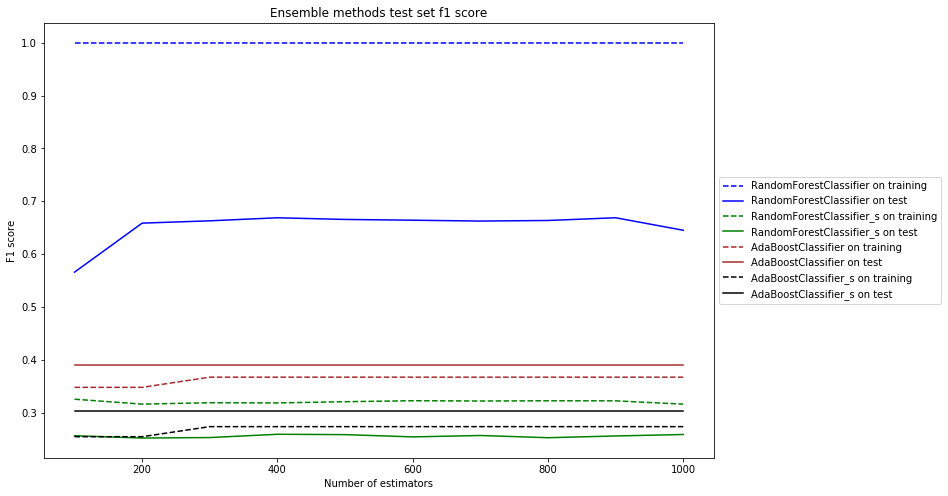

In [0]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
colors = ['blue', 'green', "brown", "black"]

for i, j, c in zip(strm, stm, colors):
  ax.plot(list(range(100, 1001, 100)), strm[i], label="{} on training".format(str(j)), linestyle="--", color=c)
  ax.plot(list(range(100, 1001, 100)), stm[j], label="{} on test".format(str(i)), color=c)
  
ax.legend()
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("F1 score")
ax.set_xlabel("Number of estimators")
ax.set_title("Ensemble methods test set f1 score")
fig.savefig("scalingcompare.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
#files.download("scalingcompare.png")

In [0]:
X_s, y_s = scaled_data(X_train, y_train)

In [0]:
rf_S = RandomForestClassifier(n_estimators=800)

In [0]:
rf_S.fit(X_s, y_s)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
y_pred_s = rf_S.predict(X_test)

In [0]:
c = confusion_matrix(y_test, y_pred_s)

In [0]:
cn = confusion_matrix(y_test, RandomForestClassifier(n_estimators=800).fit(X_train, y_train).predict(X_test))

Text(204.36, 0.5, 'predicted labels')

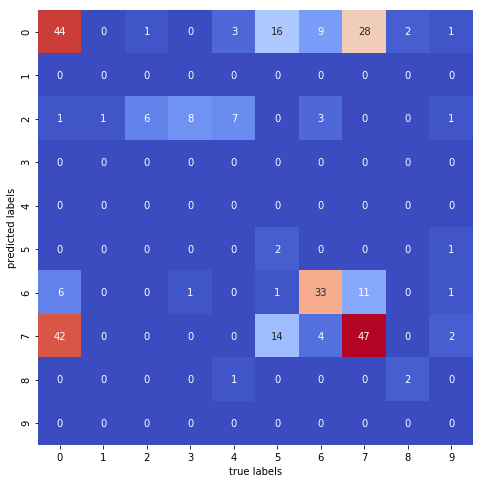

In [0]:

hm = sns.heatmap(c.T, square=True, annot=True, fmt="d", cbar=False, cmap='coolwarm')
plt.xlabel("true labels")
plt.ylabel("predicted labels")
#hm.get_figure().savefig("rfheatmap.png")
#files.download("rfheatmap.png")

Text(452.23636363636354, 0.5, 'predicted labels')

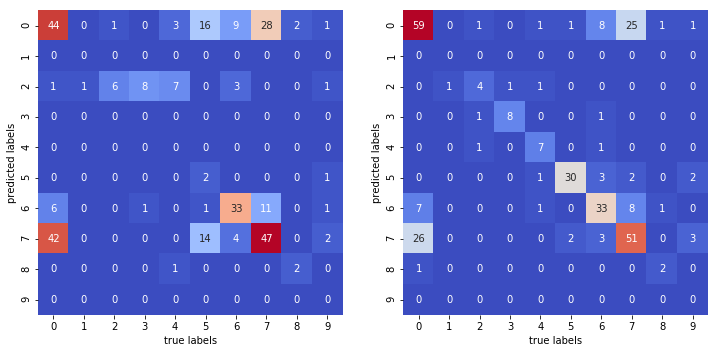

In [0]:
fig = plt.figure(figsize=(12, 8))

ax = plt.subplot(121)
hm = sns.heatmap(c.T, square=True, annot=True, fmt="d", cbar=False, cmap='coolwarm')
plt.xlabel("true labels")
plt.ylabel("predicted labels")
plt.title("Confusion matrix for scaled data")
ax = plt.subplot(122)
hmn = sns.heatmap(cn.T, square=True, annot=True, fmt="d", cbar=False, cmap='coolwarm')
plt.xlabel("true labels")
plt.ylabel("predicted labels")
plt.title("Confusion matrix for baseline data")
